In [1]:
import numpy as np
import matplotlib.pyplot as plt; plt.rc('font', size=16)
import pandas as pd
from collections import Counter
import seaborn as sns

cmap = sns.color_palette("rocket_r", as_cmap=True)

In [2]:
taxa = ['B_cellulosilyticus_WH2', 
        'B_caccae', 
        'B_vulgatus', 
        'B_thetaiotaomicron', 
        'B_ovatus', 
        'R_obeum', 
        'B_uniformis', 
        'P_distasonis', 
        'C_scindens', 
        'C_aerofaciens', 
        'C_spiroforme', 
        # 'D_longicatena'
        ]

cols = ['#016bff',
        '#b91f1c',
        '#308937',
        '#ff8137',
        '#6f4fc7',
        '#d4b300',
        '#893a2b',
        '#ff6c79',
        '#16c4ff',
        '#766f41',
        '#00c800',
        '#af3261']

# pretty_names_dir = {'B_caccae': '$B. caccae$',
#                 'B_cellulosilyticus_WH2': '$B. cellulosilyticus$',
#                 'B_ovatus': '$B. ovatus$',
#                 'B_thetaiotaomicron': '$B. thetaiotaomicron$',
#                 'B_uniformis': '$B. uniformis$',
#                 'B_vulgatus': '$B. vulgatus$',
#                 'C_aerofaciens': '$C. aerofaciens$',
#                 'C_scindens': '$C. scindens$',
#                 'C_spiroforme': '$C. spiroforme$',
#                 # 'D_longicatena': '$D. longicatena$',
#                 'P_distasonis': '$P. distasonis$',
#                 'R_obeum': '$R. obeum$'}

pretty_names_dir = {'B_caccae': 'Bca',
                'B_cellulosilyticus_WH2': 'Bce',
                'B_ovatus': 'Bov',
                'B_thetaiotaomicron': 'Bth',
                'B_uniformis': 'Bun',
                'B_vulgatus': 'Bvu',
                'C_aerofaciens': 'Cae',
                'C_scindens': 'Csc',
                'C_spiroforme': 'Csp',
                # 'D_longicatena': 'Dlo',
                'P_distasonis': 'Pdi',
                'R_obeum': 'Rob'
                }

cols_species_map = dict(zip(taxa, cols))

In [3]:
def presence_absence(x):
    if pd.isna(x):
        return 0
    else:
        return 1
    
def drop_nan(x):
    if pd.isna(x):
        return False
    else:
        return True
    
def calculate_metabolic_distance(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                set_rep = Counter(table.iloc[:,[i,j]].sum(axis=1))
                J[i,j] = 1 - (set_rep[2]/(set_rep[1]+set_rep[2]))
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_added_information(table):
    J = np.zeros([len(table.columns), len(table.columns)])
    probs = table.apply(sum, axis=1) / len(table.columns)
    for i in range(len(table.columns)):
        for j in range(len(table.columns)):
            if i == j:
                J[i,j] = 0
            else:
                K = table[(table.iloc[:,i] == 0) & (table.iloc[:,j] == 1)].copy().index
                J[i,j] = - np.sum(probs[K]*np.log2(probs[K]))
                if J[i,j] == -0:
                    J[i,j] = 0
    return pd.DataFrame(J, index=table.columns, columns=table.columns)

def get_aminoacid_metabolism(COG):
    return 'E' in COG

def get_carbohydrate_metabolism(COG):
    return 'G' in COG

# Whole Metabolism

 ## Metabolic Distance and Metabolic Added Information

In [4]:
ECs = []
for taxon in taxa:
    eggNOG = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    eggNOG['Species'] = taxon
    eggNOG = eggNOG[eggNOG['EC'] != '-'].copy()
    eggNOG.set_index('EC', inplace=True)
    eggNOG = eggNOG.loc[:,['Species']].copy()
    eggNOG.reset_index(inplace=True)
    eggNOG.set_index('Species', inplace=True)
    eggNOG = eggNOG['EC'].str.split(',', expand=True)
    eggNOG.reset_index(inplace=True)
    eggNOG = eggNOG.melt(id_vars='Species', value_name='EC')
    eggNOG.drop(columns='variable', inplace=True)
    eggNOG.dropna(inplace=True)
    eggNOG.drop_duplicates(subset=['EC'], inplace=True)
    eggNOG.set_index('EC', inplace=True)
    eggNOG.columns = [eggNOG['Species'][0]]
    ECs.append(eggNOG)
ECs = pd.concat(ECs, axis=1)
ECs = ECs.applymap(presence_absence)
ECs 

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
4.3.2.1,1,1,1,1,1,1,1,1,1,1,0
2.4.2.10,1,1,1,1,1,1,1,1,1,1,1
2.1.1.297,1,1,1,1,1,1,1,1,1,1,1
1.1.1.193,1,1,1,1,1,1,1,1,0,0,0
2.5.1.31,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
3.1.26.8,0,0,0,0,0,0,0,0,0,0,1
4.1.1.50,0,0,0,0,0,0,0,0,0,0,1
3.4.21.96,0,0,0,0,0,0,0,0,0,0,1


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


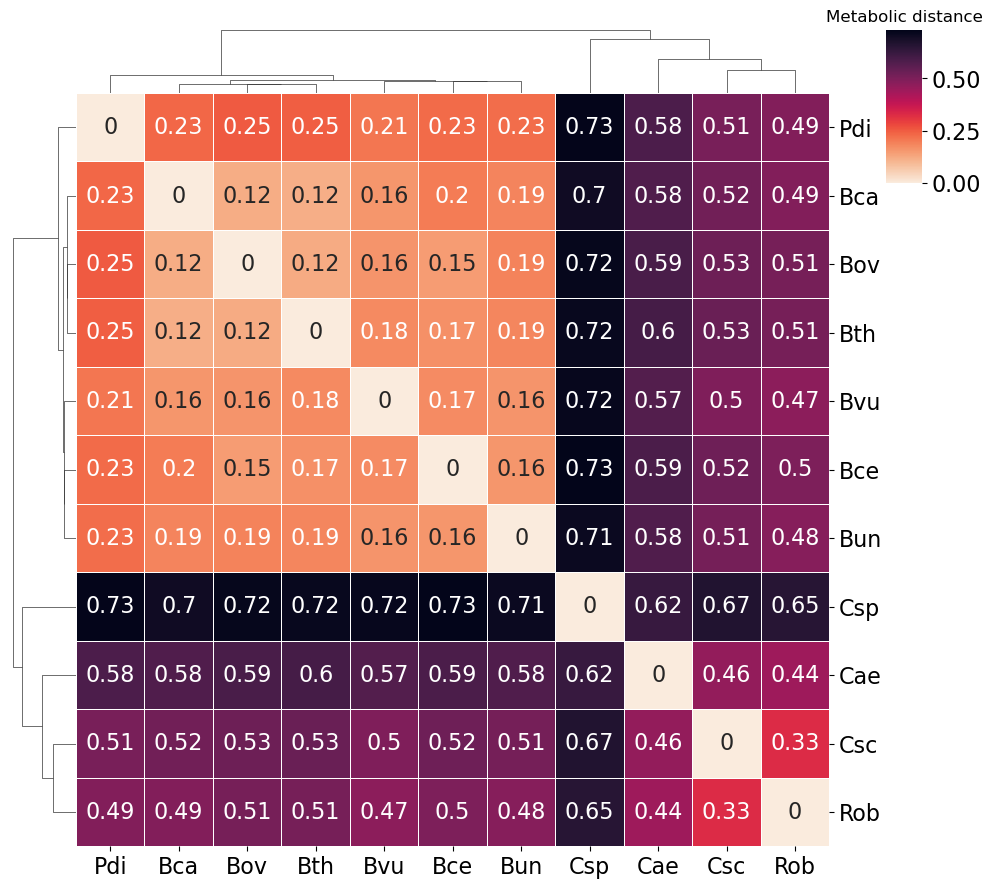

In [5]:
metdist_ECs = calculate_metabolic_distance(ECs)
metdist_ECs = metdist_ECs.sort_index(axis=0).sort_index(axis=1)
metdist_ECs.to_csv('metabolic-metrics/metdist_ECs.tsv', sep='\t', index=True, header=True)
metdist_ECs_pretty = metdist_ECs.copy()
metdist_ECs_pretty.columns = metdist_ECs_pretty.columns.map(pretty_names_dir)
metdist_ECs_pretty.index = metdist_ECs_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metdist_ECs_pretty, 
    cmap=cmap, 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(9, 9),
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
plt.title('Metabolic distance', fontsize=12)
plt.savefig('metabolic-metrics/metdist_ECs.svg', bbox_inches='tight')
plt.show()

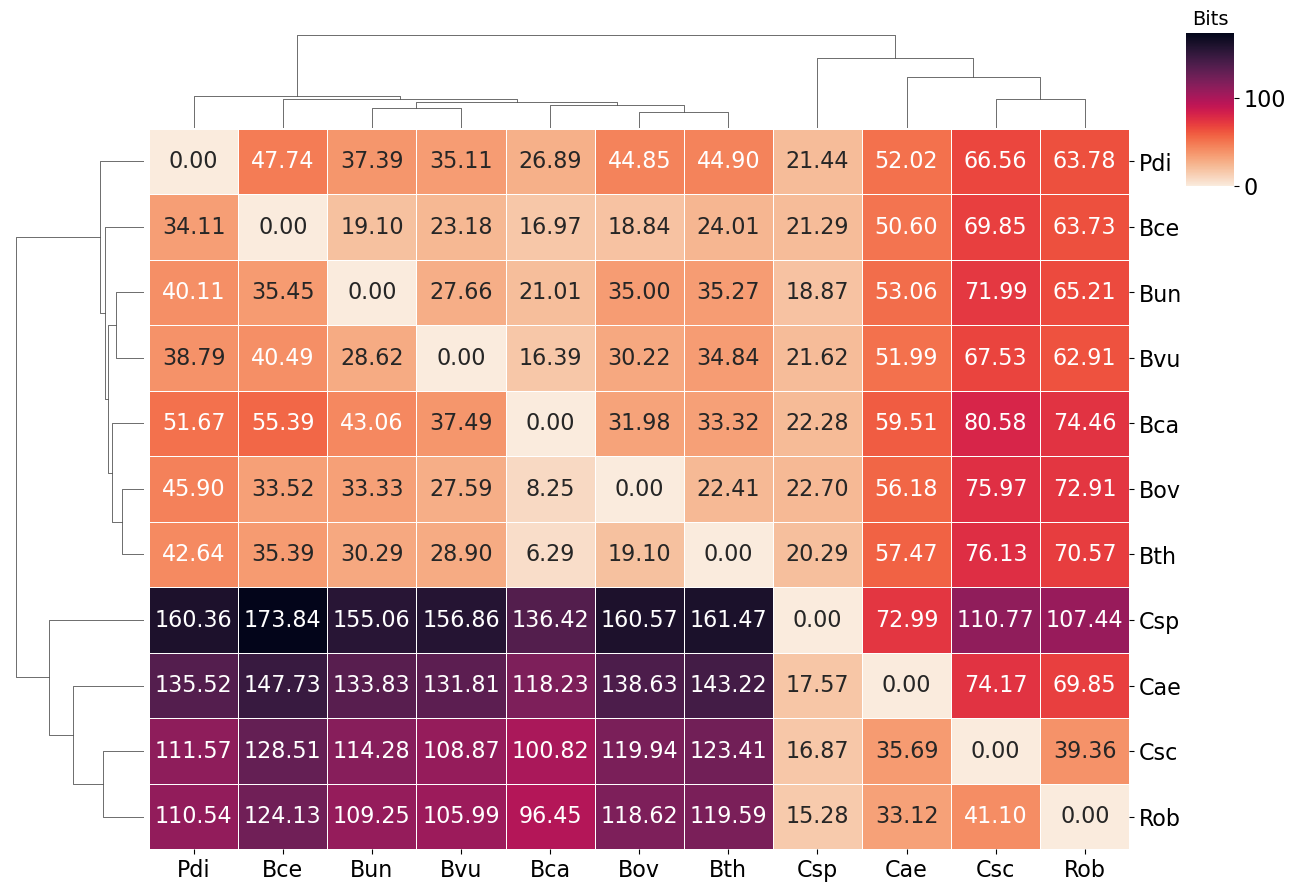

In [6]:
metaddinfo_ECs = get_added_information(ECs)
metaddinfo_ECs = metaddinfo_ECs.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs.to_csv('metabolic-metrics/metaddinfo_ECs.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_pretty = metaddinfo_ECs.copy()
metaddinfo_ECs_pretty.columns = metaddinfo_ECs_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_pretty.index = metaddinfo_ECs_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_pretty, 
    metric= 'chebyshev', 
    cmap=cmap,
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    fmt = '.2f',
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(12, 9), 
    linewidths=0.5)
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=14)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs.svg', bbox_inches='tight')
plt.show()

In [7]:
KOs = []
for taxon in taxa:
    eggNOG = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    eggNOG['Species'] = taxon
    eggNOG = eggNOG[eggNOG['KEGG_ko'] != '-'].copy()
    eggNOG.set_index('KEGG_ko', inplace=True)
    eggNOG = eggNOG.loc[:,['Species']].copy()
    eggNOG.reset_index(inplace=True)
    eggNOG.set_index('Species', inplace=True)
    eggNOG = eggNOG['KEGG_ko'].str.split(',', expand=True)
    eggNOG.reset_index(inplace=True)
    eggNOG = eggNOG.melt(id_vars='Species', value_name='KEGG_ko')
    eggNOG.drop(columns='variable', inplace=True)
    eggNOG.dropna(inplace=True)
    eggNOG.drop_duplicates(subset=['KEGG_ko'], inplace=True)
    eggNOG['KEGG_ko'] = eggNOG['KEGG_ko'].apply(lambda x: x.replace('ko:', ''))
    eggNOG.set_index('KEGG_ko', inplace=True)
    eggNOG.columns = [eggNOG['Species'][0]]
    KOs.append(eggNOG)
KOs = pd.concat(KOs, axis=1)
KOs = KOs.applymap(presence_absence)
KOs 

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
KEGG_ko,,,,,,,,,,,
K01755,1,1,1,1,1,1,1,1,1,1,0
K00762,1,1,1,1,1,1,1,1,1,1,1
K03565,1,1,1,1,1,1,1,1,1,1,0
K02493,1,1,1,1,1,1,1,1,1,1,1
K11752,1,1,1,1,1,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
K21687,0,0,0,0,0,0,0,0,0,0,1
K07093,0,0,0,0,0,0,0,0,0,0,1
K02041,0,0,0,0,0,0,0,0,0,0,1


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


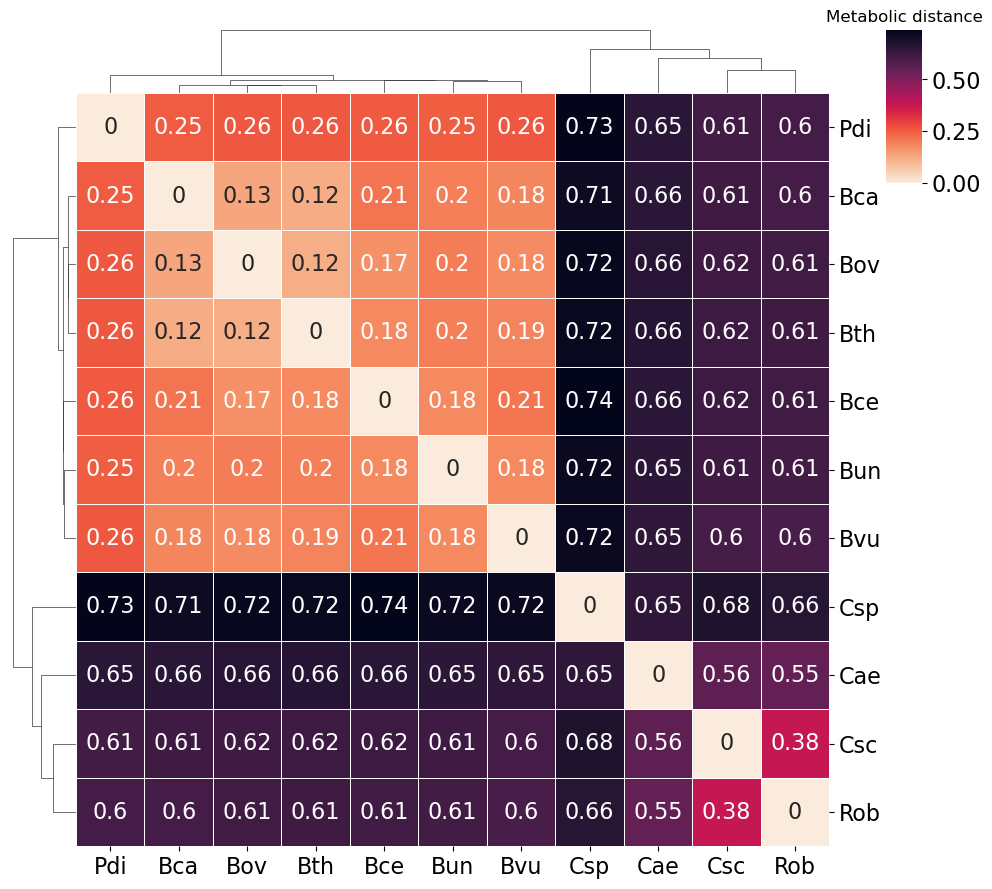

In [8]:
metdist_KOs = calculate_metabolic_distance(KOs)
metdist_KOs = metdist_KOs.sort_index(axis=0).sort_index(axis=1)
metdist_KOs.to_csv('metabolic-metrics/metdist_KOs.tsv', sep='\t', index=True, header=True)
metdist_KOs_pretty = metdist_KOs.copy()
metdist_KOs_pretty.columns = metdist_KOs_pretty.columns.map(pretty_names_dir)
metdist_KOs_pretty.index = metdist_KOs_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metdist_KOs_pretty, 
    cmap=cmap, 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(9, 9),
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
plt.title('Metabolic distance', fontsize=12)
plt.savefig('metabolic-metrics/metdist_KOs.svg', bbox_inches='tight')
plt.show()

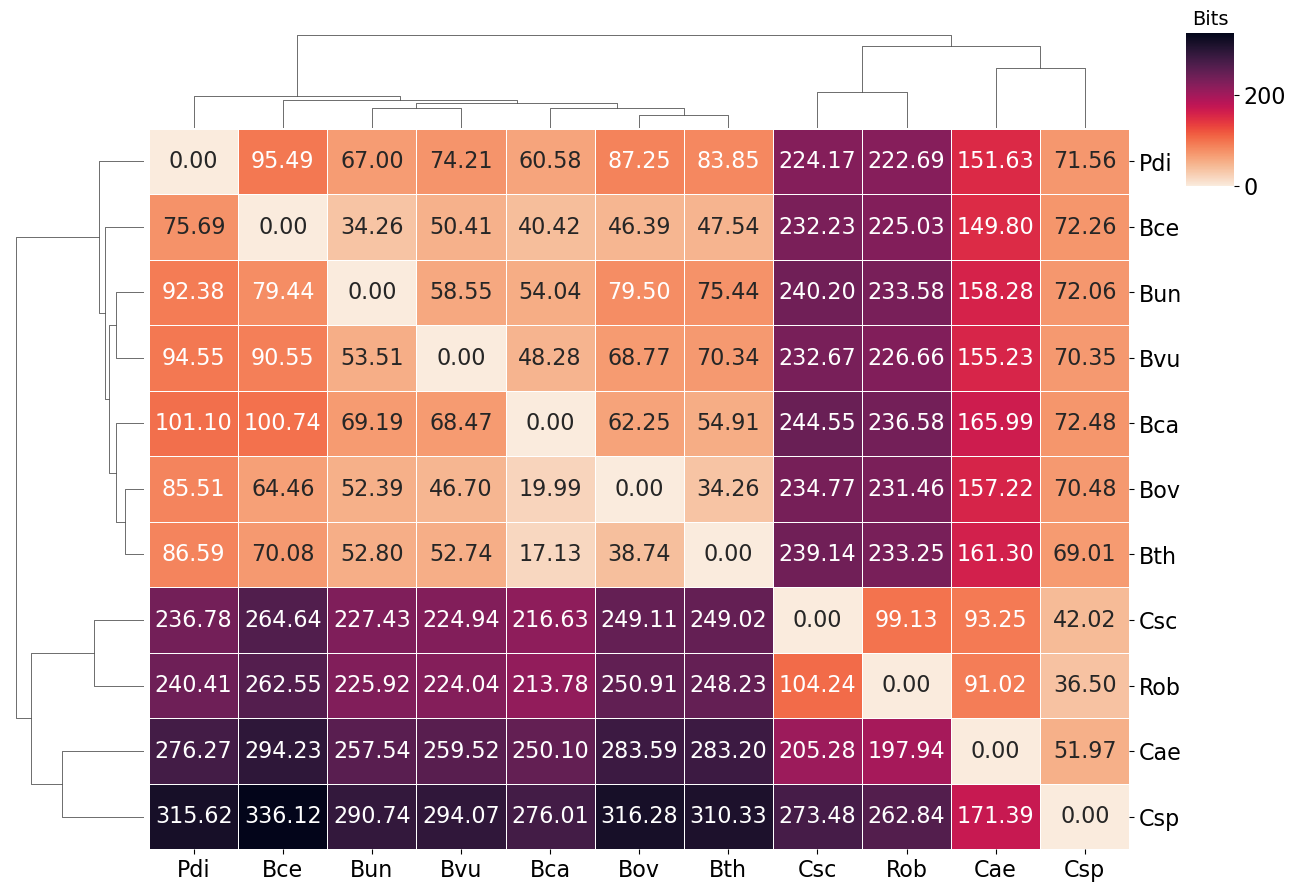

In [9]:
metaddinfo_KOs = get_added_information(KOs)
metaddinfo_KOs = metaddinfo_KOs.sort_index(axis=0).sort_index(axis=1)
metaddinfo_KOs.to_csv('metabolic-metrics/metaddinfo_KOs.tsv', sep='\t', index=True, header=True)
metaddinfo_KOs_pretty = metaddinfo_KOs.copy()
metaddinfo_KOs_pretty.columns = metaddinfo_KOs_pretty.columns.map(pretty_names_dir)
metaddinfo_KOs_pretty.index = metaddinfo_KOs_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_KOs_pretty, 
    metric= 'chebyshev', 
    cmap=cmap,
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    fmt = '.2f',
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(12, 9), 
    linewidths=0.5)
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_KOs.svg', bbox_inches='tight')
plt.show()

# Carbohydrate metabolism

## Metabolic Distance and Metabolic Added Information

In [10]:
dbCAN_sub = []
for taxon in taxa:
    cazymes = pd.read_table(f'dbCAN3/{taxon}/overview.txt', sep='\t', index_col=1)
    cazymes['Species'] = taxon
    cazymes = cazymes[cazymes['#ofTools'] >= 2].loc[:, ['Species']].copy()
    cazymes.reset_index(inplace=True)
    cazymes.set_index('Species', inplace=True)
    cazymes = cazymes['EC#'].str.split('|', expand=True)
    cazymes.reset_index(inplace=True)
    cazymes = cazymes.melt(id_vars='Species', value_name='EC#')
    cazymes.drop(columns='variable', inplace=True)
    cazymes.dropna(inplace=True)
    cazymes = cazymes[cazymes['EC#'] != '-'].copy()
    cazymes.drop_duplicates(subset=['EC#'], inplace=True)
    cazymes.set_index('EC#', inplace=True)
    cazymes.columns = [cazymes['Species'][0]]
    dbCAN_sub.append(cazymes)
dbCAN_sub = pd.concat(dbCAN_sub, axis=1)
dbCAN_sub = dbCAN_sub.applymap(presence_absence)
dbCAN_sub

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC#,,,,,,,,,,,
3.2.1.55,1,1,1,1,1,1,1,1,0,0,0
3.2.1.37,1,1,1,1,1,1,1,1,0,1,1
3.2.1.-,1,1,1,1,1,1,1,1,1,1,1
3.2.1.92,1,0,0,0,0,0,1,0,0,0,0
3.2.1.21,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
4.2.2.12,0,0,0,0,0,0,0,0,0,0,1
3.2.1.97,0,0,0,0,0,0,0,0,0,0,1
3.2.1.50,0,0,0,0,0,0,0,0,0,0,1


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


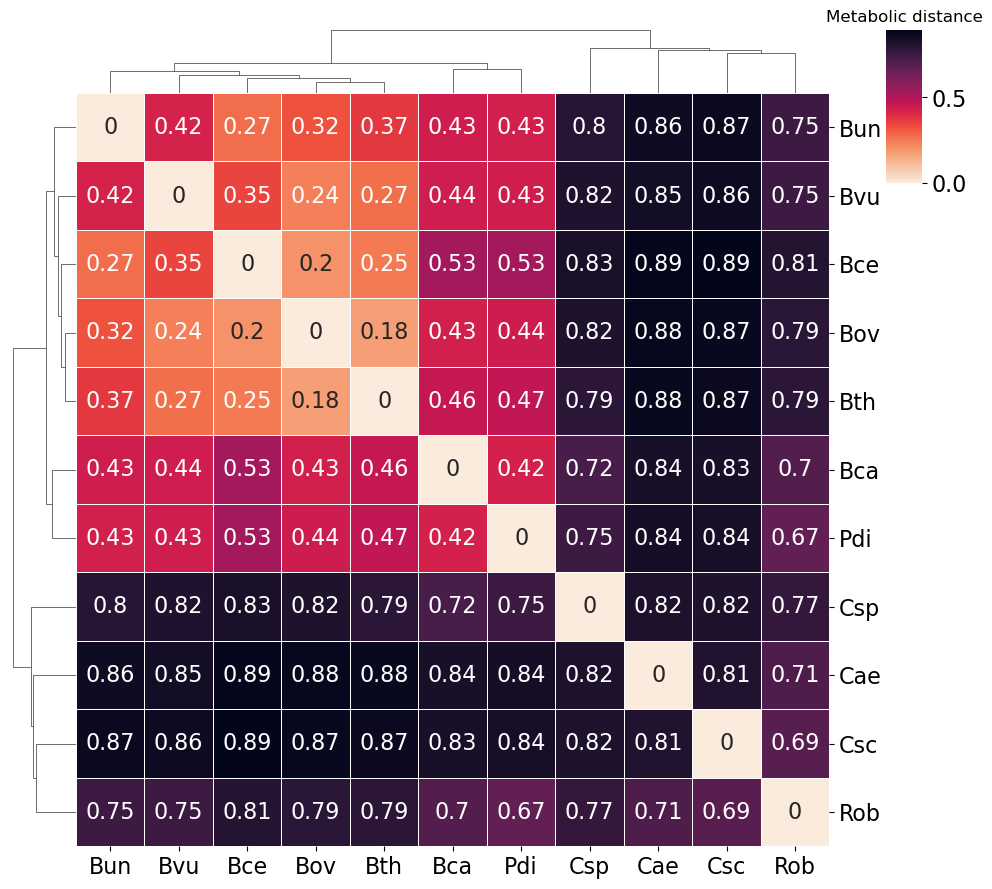

In [11]:
metdist_carbo = calculate_metabolic_distance(dbCAN_sub)
metdist_carbo = metdist_carbo.sort_index(axis=0).sort_index(axis=1)
metdist_carbo.to_csv('metabolic-metrics/metdist_carbo.tsv', sep='\t', index=True, header=True)
metdist_carbo_pretty = metdist_carbo.copy()
metdist_carbo_pretty.columns = metdist_carbo_pretty.columns.map(pretty_names_dir)
metdist_carbo_pretty.index = metdist_carbo_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metdist_carbo_pretty, 
    cmap=cmap,
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    linewidths=0.5,
    figsize=(9, 9))
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
plt.title('Metabolic distance', fontsize=12)
plt.savefig('metabolic-metrics/metdist_carbo.svg', bbox_inches='tight')
plt.show()

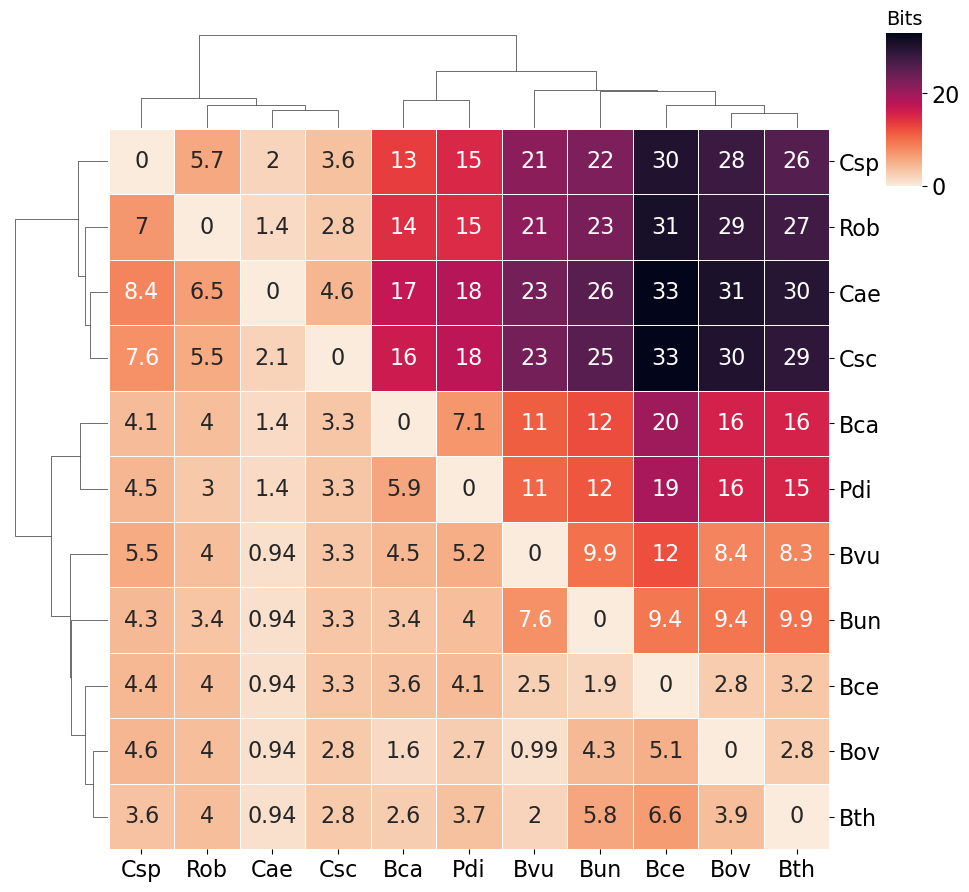

In [12]:
metaddinfo_carbo = get_added_information(dbCAN_sub)
metaddinfo_carbo = metaddinfo_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_carbo.to_csv('metabolic-metrics/metaddinfo_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_carbo_pretty = metaddinfo_carbo.copy()
metaddinfo_carbo_pretty.columns = metaddinfo_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_carbo_pretty.index = metaddinfo_carbo_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_carbo_pretty, 
    metric= 'chebyshev', 
    cmap=cmap,
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5)
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_carbo.svg', bbox_inches='tight')
plt.show()

# Amino Acid Metabolism

 ## Metabolic distance and Metabolic Added Information

In [13]:
eggNOG = []
for taxon in taxa:
    aminoacid_metabolism = pd.read_table(f'eggNOG/{taxon}_eggNOG.tsv', index_col=0, skiprows=4, skipfooter=3, engine='python')
    aminoacid_metabolism['Species'] = taxon
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['COG_category'].apply(get_aminoacid_metabolism)].copy()
    aminoacid_metabolism = aminoacid_metabolism[aminoacid_metabolism['EC'] != '-'].copy()
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.loc[:,['Species']].copy()
    aminoacid_metabolism.reset_index(inplace=True)
    aminoacid_metabolism.set_index('Species', inplace=True)
    aminoacid_metabolism = aminoacid_metabolism['EC'].str.split(',', expand=True)
    aminoacid_metabolism.reset_index(inplace=True)
    aminoacid_metabolism = aminoacid_metabolism.melt(id_vars='Species', value_name='EC')
    aminoacid_metabolism.drop(columns='variable', inplace=True)
    aminoacid_metabolism.dropna(inplace=True)
    aminoacid_metabolism.drop_duplicates(subset=['EC'], inplace=True)
    aminoacid_metabolism.set_index('EC', inplace=True)
    aminoacid_metabolism.columns = [aminoacid_metabolism['Species'][0]]
    eggNOG.append(aminoacid_metabolism)
eggNOG = pd.concat(eggNOG, axis=1)
eggNOG = eggNOG.applymap(presence_absence)
eggNOG 

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
4.3.2.1,1,1,1,1,1,1,1,1,1,1,0
2.7.2.11,1,1,1,1,1,0,1,1,0,1,1
1.2.1.41,1,1,1,1,1,1,1,1,1,1,1
2.1.3.11,1,1,1,1,1,0,1,1,0,0,0
1.2.1.11,1,1,1,1,1,0,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...
1.1.1.399,0,0,0,0,0,0,0,0,0,1,0
2.4.2.17,0,0,0,0,0,0,0,0,0,1,0
1.1.1.41,0,0,0,0,0,0,0,0,0,1,0


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


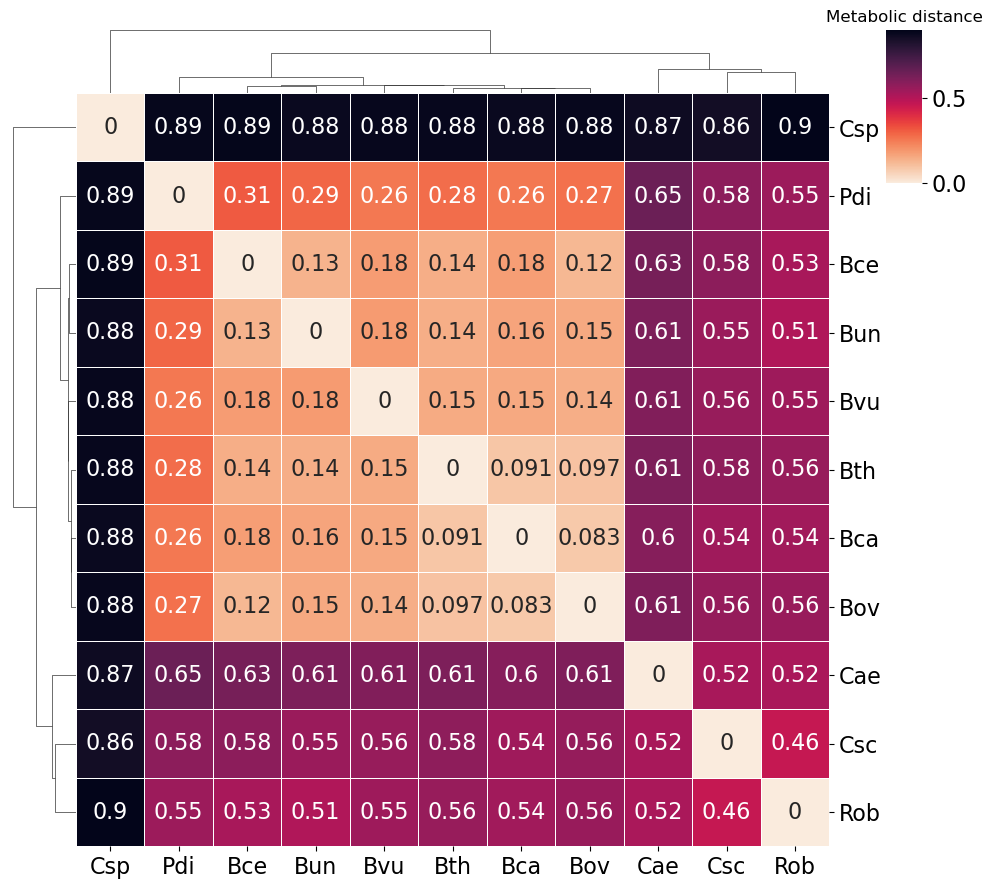

In [14]:
metdist_amino = calculate_metabolic_distance(eggNOG)
metdist_amino = metdist_amino.sort_index(axis=0).sort_index(axis=1)
metdist_amino.to_csv('metabolic-metrics/metdist_amino.tsv', sep='\t', index=True, header=True)
metdist_amino_pretty = metdist_amino.copy()
metdist_amino_pretty.columns = metdist_amino_pretty.columns.map(pretty_names_dir)
metdist_amino_pretty.index = metdist_amino_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metdist_amino_pretty, 
    cmap=cmap, 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(9, 9),
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
plt.title('Metabolic distance', fontsize=12)
plt.savefig('metabolic-metrics/metdist_amino.svg', bbox_inches='tight')
plt.show()

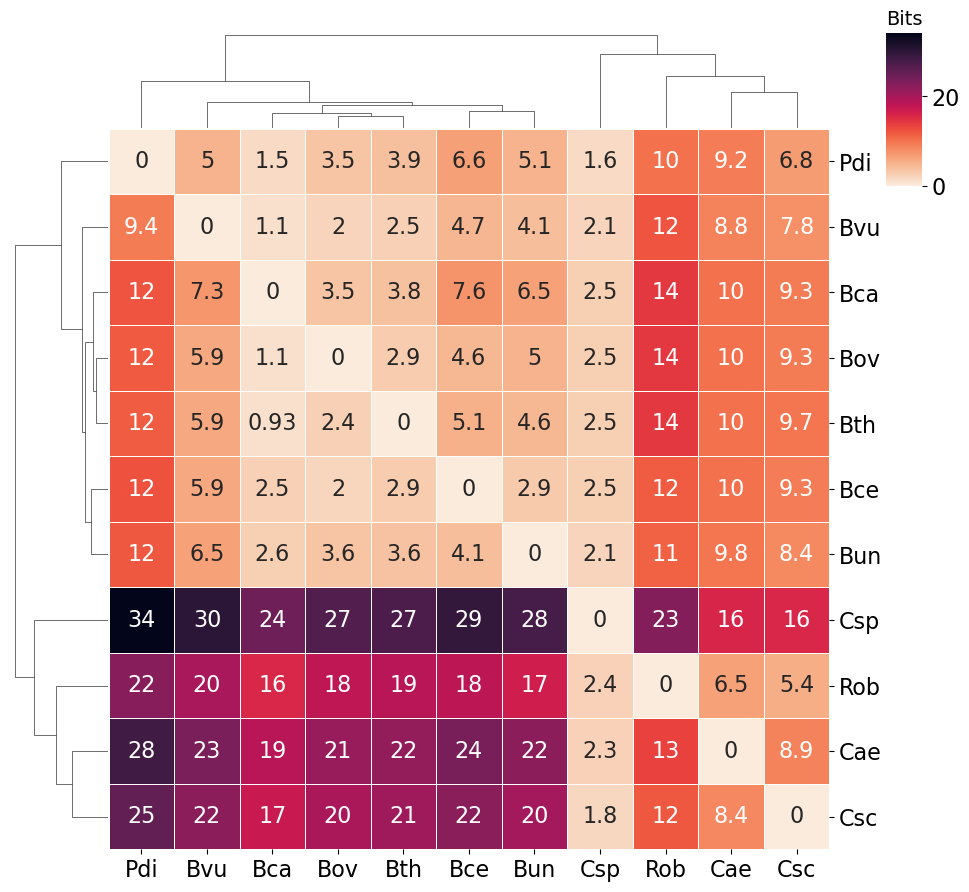

In [15]:
metaddinfo_amino = get_added_information(eggNOG)
metaddinfo_amino = metaddinfo_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_amino.to_csv('metabolic-metrics/metaddinfo_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_amino_pretty = metaddinfo_amino.copy()
metaddinfo_amino_pretty.columns = metaddinfo_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_amino_pretty.index = metaddinfo_amino_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_amino_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5)
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_amino.svg', bbox_inches='tight')
plt.show()

# Carbohydrate and Amino Acid Metabolism

 ## Metabolic Distance and Metabolic Added Information

In [16]:
dbCAN_sub_eggNOG = pd.concat([dbCAN_sub, eggNOG], axis=0)
dbCAN_sub_eggNOG

,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
3.2.1.55,1,1,1,1,1,1,1,1,0,0,0
3.2.1.37,1,1,1,1,1,1,1,1,0,1,1
3.2.1.-,1,1,1,1,1,1,1,1,1,1,1
3.2.1.92,1,0,0,0,0,0,1,0,0,0,0
3.2.1.21,1,1,1,1,1,1,1,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
1.1.1.399,0,0,0,0,0,0,0,0,0,1,0
2.4.2.17,0,0,0,0,0,0,0,0,0,1,0
1.1.1.41,0,0,0,0,0,0,0,0,0,1,0
2.1.3.6,0,0,0,0,0,0,0,0,0,1,0


/home/acs98/anaconda3/envs/py-workspace/lib/python3.11/site-packages/seaborn/matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


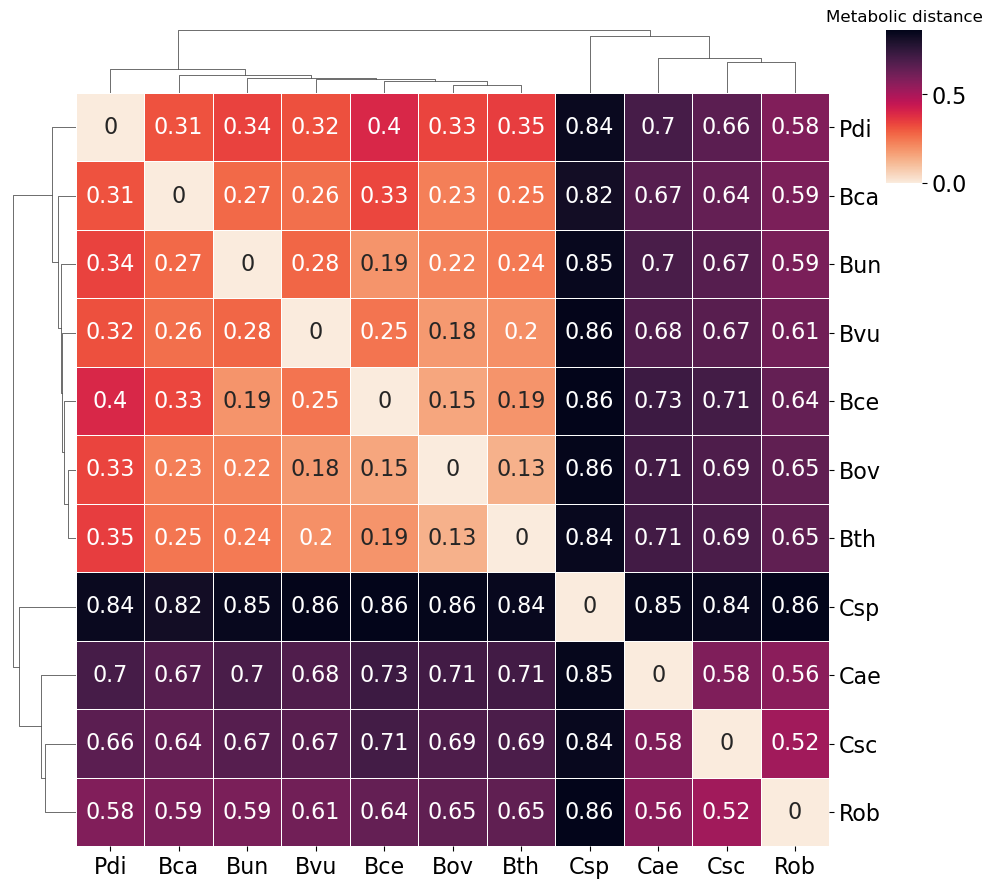

In [17]:
metdist_carbo_amino = calculate_metabolic_distance(dbCAN_sub_eggNOG)
metdist_carbo_amino = metdist_carbo_amino.sort_index(axis=0).sort_index(axis=1)
metdist_carbo_amino.to_csv('metabolic-metrics/metdist_carbo_amino.tsv', sep='\t', index=True, header=True)
metdist_carbo_amino_pretty = metdist_carbo_amino.copy()
metdist_carbo_amino_pretty.columns = metdist_carbo_amino_pretty.columns.map(pretty_names_dir)
metdist_carbo_amino_pretty.index = metdist_carbo_amino_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metdist_carbo_amino_pretty, 
    cmap=cmap, 
    row_cluster=True, 
    col_cluster=True,
    dendrogram_ratio=(0.08, 0.08), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17),
    yticklabels='auto',
    xticklabels='auto',
    figsize=(9, 9),
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
plt.title('Metabolic distance', fontsize=12)
plt.savefig('metabolic-metrics/metdist_carbo_amino.svg', bbox_inches='tight')
plt.show()

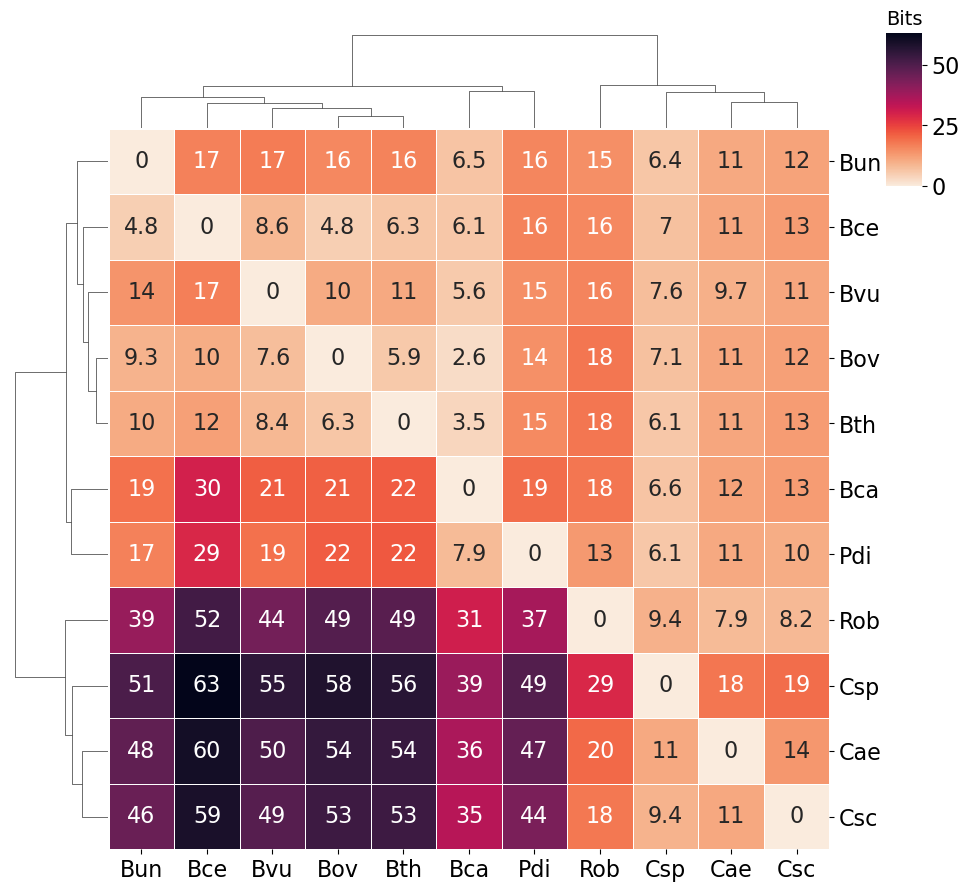

In [18]:
metaddinfo_carbo_amino = get_added_information(dbCAN_sub_eggNOG)
metaddinfo_carbo_amino = metaddinfo_carbo_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_carbo_amino.to_csv('metabolic-metrics/metaddinfo_carbo_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_carbo_amino_pretty = metaddinfo_carbo_amino.copy()
metaddinfo_carbo_amino_pretty.columns = metaddinfo_carbo_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_carbo_amino_pretty.index = metaddinfo_carbo_amino_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_carbo_amino_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_carbo_amino.svg', bbox_inches='tight')
plt.show()

# Guided Whole Metabolism

## Metabolic Added Information

In [19]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int = exp_mcnulty.loc[:,['EC']]
ecs_int = ecs_int['EC'].str.split('; ', expand=True)
ecs_int.reset_index(inplace=True)
ecs_int = ecs_int.melt(id_vars='Index', value_name='EC')
ecs_int = ecs_int.dropna()
ecs_int = ecs_int['EC'].values
print(ecs_int.shape)
ECs_int = ECs[ECs.index.isin(ecs_int)]
ECs_int

(163,)


,B_cellulosilyticus_WH2,B_caccae,B_vulgatus,B_thetaiotaomicron,B_ovatus,R_obeum,B_uniformis,P_distasonis,C_scindens,C_aerofaciens,C_spiroforme
EC,,,,,,,,,,,
2.7.2.1,1,1,1,1,1,1,1,1,1,1,1
5.3.1.4,1,1,1,1,1,1,1,0,0,0,0
2.6.1.37,1,1,1,1,1,0,1,1,0,0,0
4.2.2.20,1,1,0,1,1,0,1,0,0,0,0
3.2.1.4,1,0,0,1,1,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1.21.4.4,0,0,0,0,0,0,0,0,1,0,0
3.5.3.6,0,0,0,0,0,0,0,0,0,1,0
4.1.1.31,0,0,0,0,0,0,0,0,0,1,0


(84,)


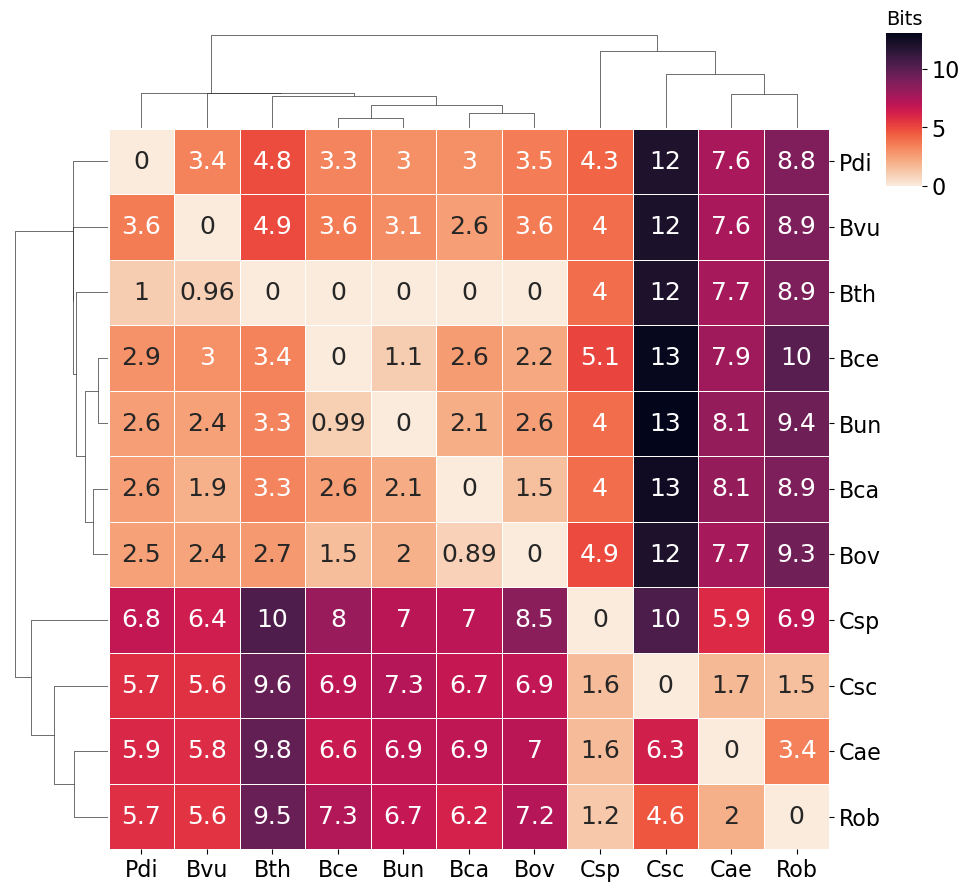

In [20]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_hf = exp_mcnulty.loc[1:81,['EC']]
ecs_int_hf = ecs_int_hf['EC'].str.split('; ', expand=True)
ecs_int_hf.reset_index(inplace=True)
ecs_int_hf = ecs_int_hf.melt(id_vars='Index', value_name='EC')
ecs_int_hf = ecs_int_hf.dropna()
ecs_int_hf = ecs_int_hf['EC'].values
print(ecs_int_hf.shape)
ECs_int_hf = ECs[ECs.index.isin(ecs_int_hf)]

metaddinfo_ECs_int_hf = get_added_information(ECs_int_hf)
metaddinfo_ECs_int_hf = metaddinfo_ECs_int_hf.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_hf.to_csv('metabolic-metrics/metaddinfo_ECs_int_hf.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_hf_pretty = metaddinfo_ECs_int_hf.copy()
metaddinfo_ECs_int_hf_pretty.columns = metaddinfo_ECs_int_hf_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_hf_pretty.index = metaddinfo_ECs_int_hf_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_int_hf_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    annot_kws={'size': 18},
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_hf.svg', bbox_inches='tight')
plt.show()

(79,)


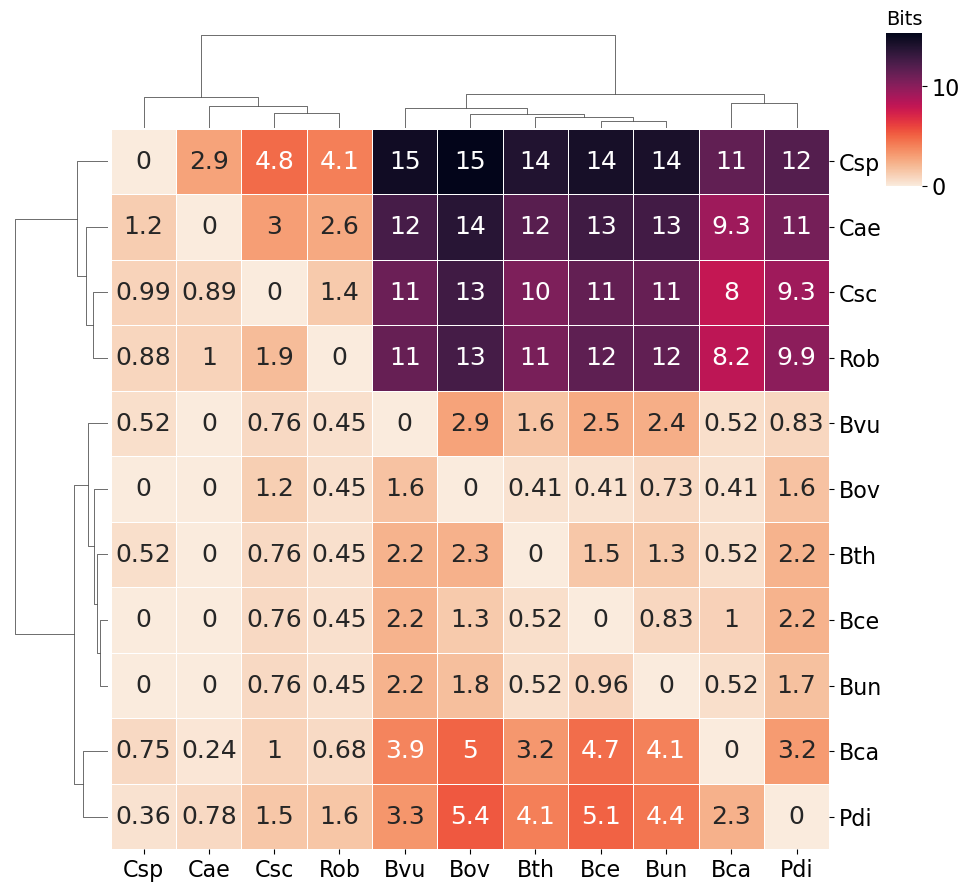

In [21]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_lf = exp_mcnulty.loc[82:157,['EC']]
ecs_int_lf = ecs_int_lf['EC'].str.split('; ', expand=True)
ecs_int_lf.reset_index(inplace=True)
ecs_int_lf = ecs_int_lf.melt(id_vars='Index', value_name='EC')
ecs_int_lf = ecs_int_lf.dropna()
ecs_int_lf = ecs_int_lf['EC'].values
print(ecs_int_lf.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_lf)]

metaddinfo_ECs_int_lf = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_lf = metaddinfo_ECs_int_lf.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_lf.to_csv('metabolic-metrics/metaddinfo_ECs_int_lf.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_lf_pretty = metaddinfo_ECs_int_lf.copy()
metaddinfo_ECs_int_lf_pretty.columns = metaddinfo_ECs_int_lf_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_lf_pretty.index = metaddinfo_ECs_int_lf_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_int_lf_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    annot_kws={'size': 18},
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_lf.svg', bbox_inches='tight')
plt.show()

# Metabolism specificity

(24,)


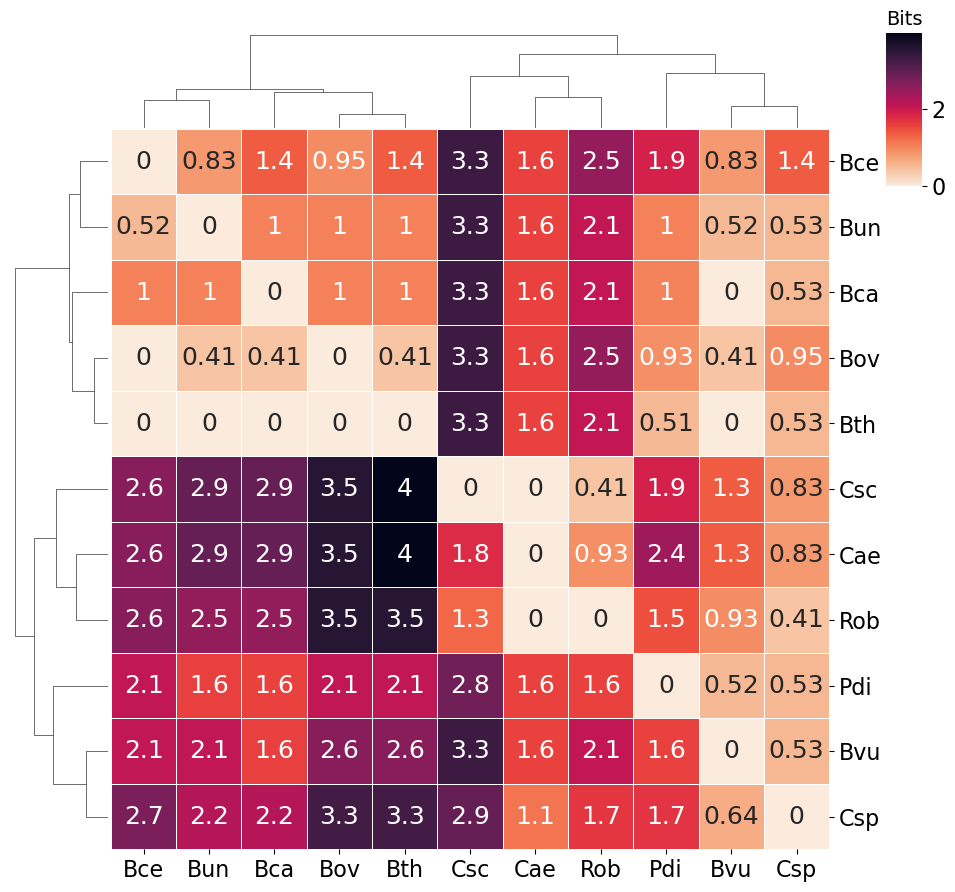

In [22]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_hf_carbo = exp_mcnulty.loc[1:81,['EC','Carbohydrate_metabolism']].dropna()
ecs_int_hf_carbo.drop(columns=['Carbohydrate_metabolism'], inplace=True)
ecs_int_hf_carbo = ecs_int_hf_carbo['EC'].str.split('; ', expand=True)
ecs_int_hf_carbo.reset_index(inplace=True)
ecs_int_hf_carbo = ecs_int_hf_carbo.melt(id_vars='Index', value_name='EC')
ecs_int_hf_carbo = ecs_int_hf_carbo.dropna()
ecs_int_hf_carbo = ecs_int_hf_carbo['EC'].values
print(ecs_int_hf_carbo.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_hf_carbo)]

metaddinfo_ECs_int_hf_carbo = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_hf_carbo = metaddinfo_ECs_int_hf_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_hf_carbo.to_csv('metabolic-metrics/metaddinfo_ECs_int_hf_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_hf_carbo_pretty = metaddinfo_ECs_int_hf_carbo.copy()
metaddinfo_ECs_int_hf_carbo_pretty.columns = metaddinfo_ECs_int_hf_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_hf_carbo_pretty.index = metaddinfo_ECs_int_hf_carbo_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_int_hf_carbo_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    annot_kws={'size': 18},
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_hf_carbo.svg', bbox_inches='tight')
plt.show()

(19,)


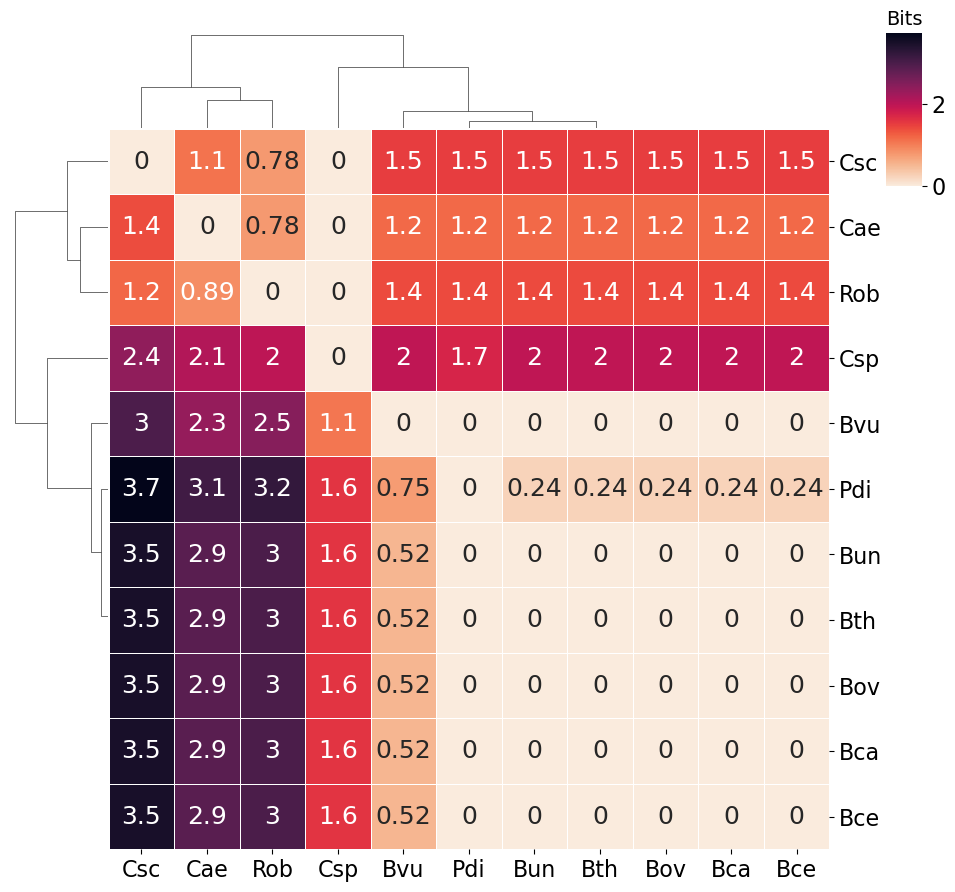

In [23]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_hf_amino = exp_mcnulty.loc[1:81,['EC','Aminocid_metabolism']].dropna()
ecs_int_hf_amino.drop(columns=['Aminocid_metabolism'], inplace=True)
ecs_int_hf_amino = ecs_int_hf_amino['EC'].str.split('; ', expand=True)
ecs_int_hf_amino.reset_index(inplace=True)
ecs_int_hf_amino = ecs_int_hf_amino.melt(id_vars='Index', value_name='EC')
ecs_int_hf_amino = ecs_int_hf_amino.dropna()
ecs_int_hf_amino = ecs_int_hf_amino['EC'].values
print(ecs_int_hf_amino.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_hf_amino)]

metaddinfo_ECs_int_hf_amino = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_hf_amino = metaddinfo_ECs_int_hf_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_hf_amino.to_csv('metabolic-metrics/metaddinfo_ECs_int_hf_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_hf_amino_pretty = metaddinfo_ECs_int_hf_amino.copy()
metaddinfo_ECs_int_hf_amino_pretty.columns = metaddinfo_ECs_int_hf_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_hf_amino_pretty.index = metaddinfo_ECs_int_hf_amino_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_int_hf_amino_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    annot_kws={'size': 18},
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_hf_amino.svg', bbox_inches='tight')
plt.show()

(28,)


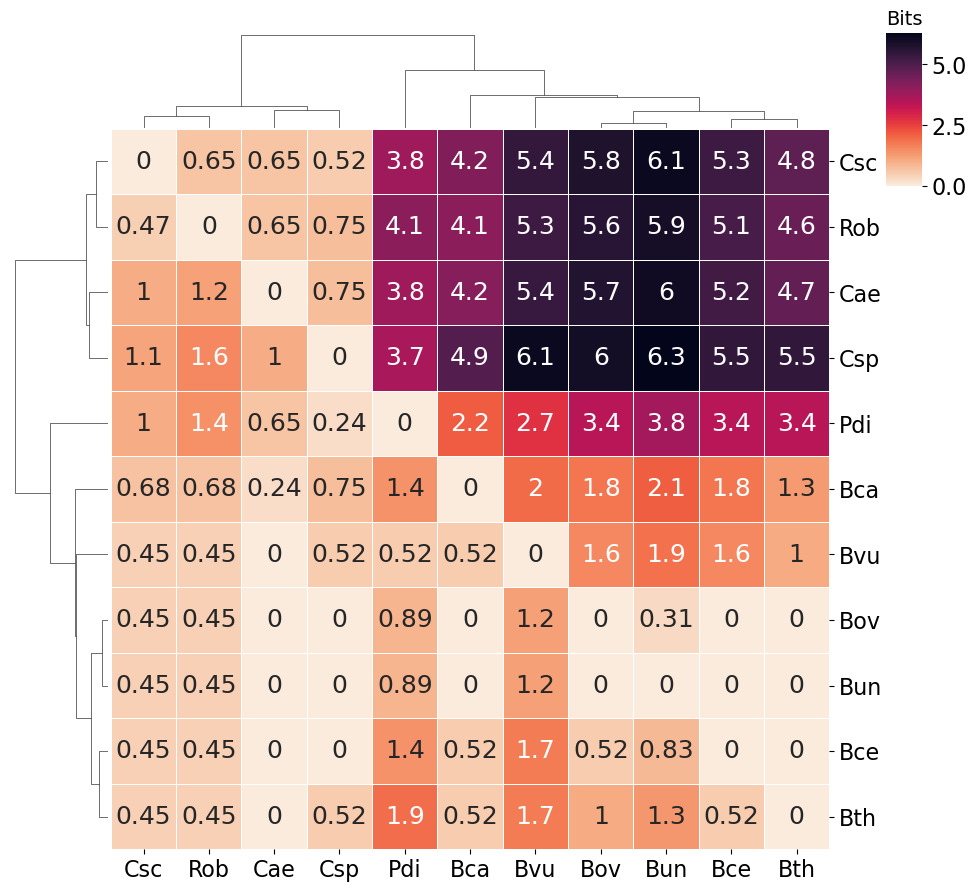

In [24]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_lf_carbo = exp_mcnulty.loc[82:158,['EC','Carbohydrate_metabolism']].dropna()
ecs_int_lf_carbo.drop(columns=['Carbohydrate_metabolism'], inplace=True)
ecs_int_lf_carbo = ecs_int_lf_carbo['EC'].str.split('; ', expand=True)
ecs_int_lf_carbo.reset_index(inplace=True)
ecs_int_lf_carbo = ecs_int_lf_carbo.melt(id_vars='Index', value_name='EC')
ecs_int_lf_carbo = ecs_int_lf_carbo.dropna()
ecs_int_lf_carbo = ecs_int_lf_carbo['EC'].values
print(ecs_int_lf_carbo.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_lf_carbo)]

metaddinfo_ECs_int_lf_carbo = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_lf_carbo = metaddinfo_ECs_int_lf_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_lf_carbo.to_csv('metabolic-metrics/metaddinfo_ECs_int_lf_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_lf_carbo_pretty = metaddinfo_ECs_int_lf_carbo.copy()
metaddinfo_ECs_int_lf_carbo_pretty.columns = metaddinfo_ECs_int_lf_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_lf_carbo_pretty.index = metaddinfo_ECs_int_lf_carbo_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_int_lf_carbo_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    annot_kws={'size': 18},
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_lf_carbo.svg', bbox_inches='tight')
plt.show()

(25,)


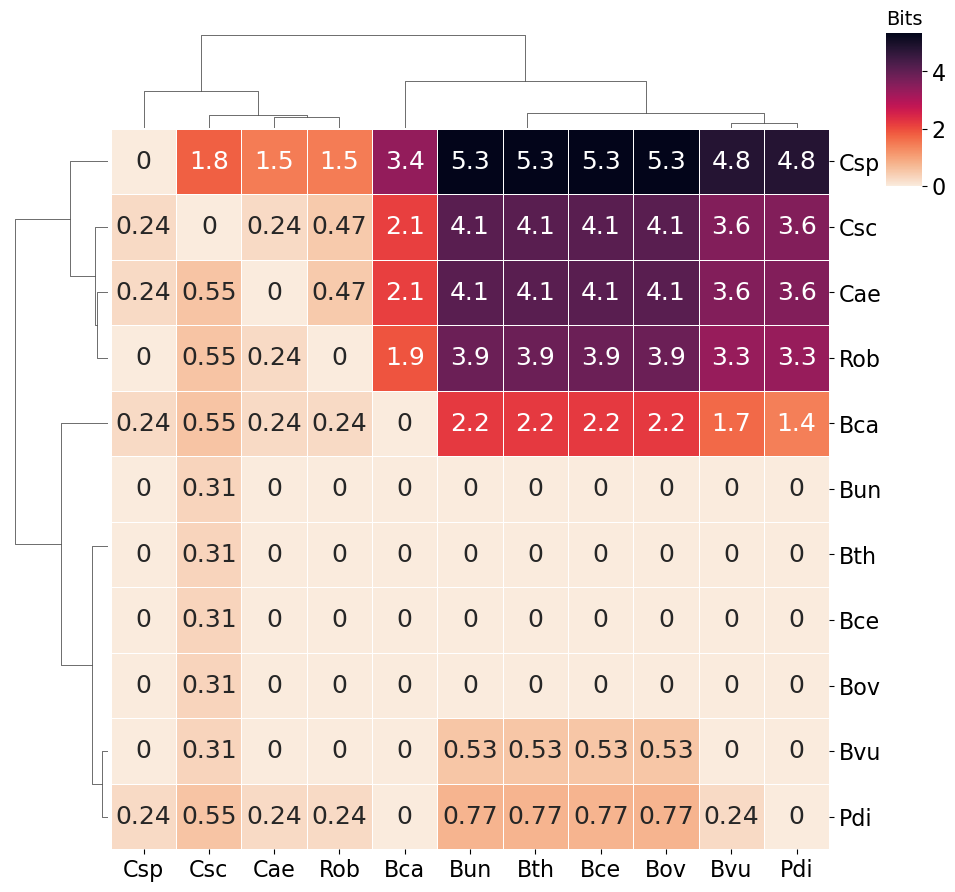

In [25]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_df_amino = exp_mcnulty.loc[82:158,['EC','Aminocid_metabolism']].dropna()
ecs_int_df_amino.drop(columns=['Aminocid_metabolism'], inplace=True)
ecs_int_df_amino = ecs_int_df_amino['EC'].str.split('; ', expand=True)
ecs_int_df_amino.reset_index(inplace=True)
ecs_int_df_amino = ecs_int_df_amino.melt(id_vars='Index', value_name='EC')
ecs_int_df_amino = ecs_int_df_amino.dropna()
ecs_int_df_amino = ecs_int_df_amino['EC'].values
print(ecs_int_df_amino.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_df_amino)]

metaddinfo_ECs_int_lf_amino = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_lf_amino = metaddinfo_ECs_int_lf_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_lf_amino.to_csv('metabolic-metrics/metaddinfo_ECs_int_lf_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_lf_amino_pretty = metaddinfo_ECs_int_lf_amino.copy()
metaddinfo_ECs_int_lf_amino_pretty.columns = metaddinfo_ECs_int_lf_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_lf_amino_pretty.index = metaddinfo_ECs_int_lf_amino_pretty.index.map(pretty_names_dir)
ax = sns.clustermap(metaddinfo_ECs_int_lf_amino_pretty, 
    metric= 'chebyshev', 
    cmap=cmap, 
    dendrogram_ratio=(0.12, 0.12), 
    annot=True, 
    annot_kws={'size': 18},
    cbar_pos=(1, 0.8, 0.04, 0.17), 
    figsize=(9, 9), 
    linewidths=0.5,
    )
cax = ax.ax_heatmap
cax.set_xticklabels(cax.get_xticklabels(), rotation=0, ha='center')
cax.set_yticklabels(cax.get_yticklabels(), rotation=0, ha='left')
# plt.title('Metabolic added\ninformation', fontsize=12)
plt.title('Bits', fontsize=14)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_lf_amino.svg', bbox_inches='tight')
plt.show()

## Heatmaps

In [26]:
order_hm = ['Bce', 'Bov', 'Bth', 'Bvu', 'Bun', 'Bca', 'Pdi', 'Csc', 'Rob', 'Csp', 'Cae']

(84,)


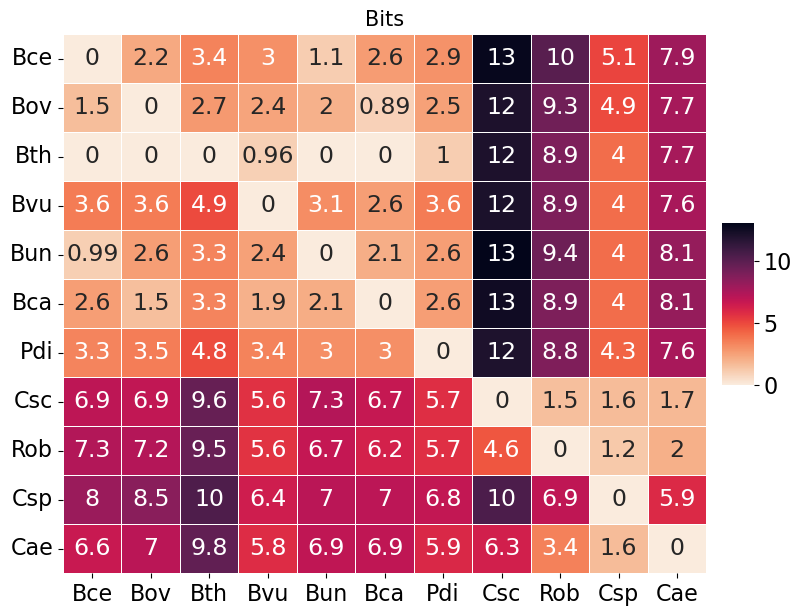

In [27]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_hf = exp_mcnulty.loc[1:81,['EC']]
ecs_int_hf = ecs_int_hf['EC'].str.split('; ', expand=True)
ecs_int_hf.reset_index(inplace=True)
ecs_int_hf = ecs_int_hf.melt(id_vars='Index', value_name='EC')
ecs_int_hf = ecs_int_hf.dropna()
ecs_int_hf = ecs_int_hf['EC'].values
print(ecs_int_hf.shape)
ECs_int_hf = ECs[ECs.index.isin(ecs_int_hf)]

metaddinfo_ECs_int_hf = get_added_information(ECs_int_hf)
metaddinfo_ECs_int_hf = metaddinfo_ECs_int_hf.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_hf.to_csv('metabolic-metrics/metaddinfo_ECs_int_hf.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_hf_pretty = metaddinfo_ECs_int_hf.copy()
metaddinfo_ECs_int_hf_pretty.columns = metaddinfo_ECs_int_hf_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_hf_pretty.index = metaddinfo_ECs_int_hf_pretty.index.map(pretty_names_dir)
metaddinfo_ECs_int_hf_pretty = metaddinfo_ECs_int_hf_pretty.loc[order_hm, order_hm]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(metaddinfo_ECs_int_hf_pretty, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_hf.svg', bbox_inches='tight')
plt.show()

(79,)


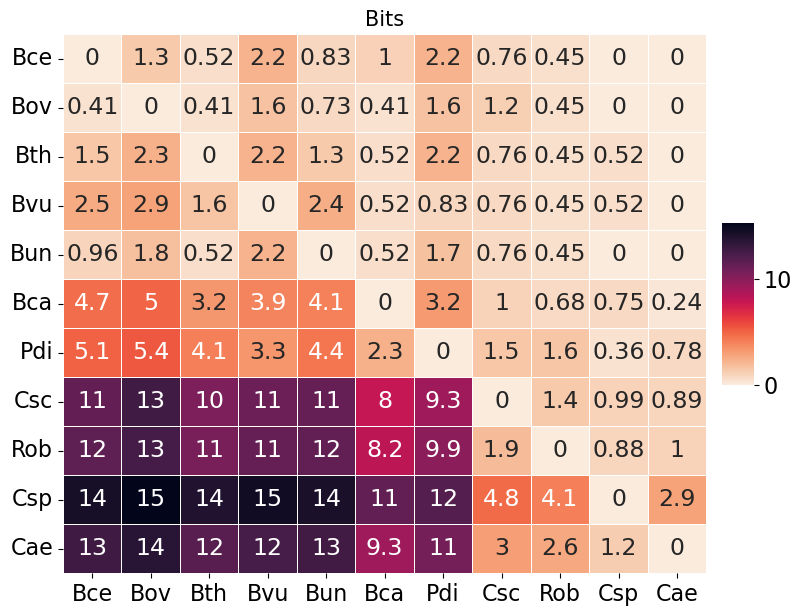

In [28]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_lf = exp_mcnulty.loc[82:157,['EC']]
ecs_int_lf = ecs_int_lf['EC'].str.split('; ', expand=True)
ecs_int_lf.reset_index(inplace=True)
ecs_int_lf = ecs_int_lf.melt(id_vars='Index', value_name='EC')
ecs_int_lf = ecs_int_lf.dropna()
ecs_int_lf = ecs_int_lf['EC'].values
print(ecs_int_lf.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_lf)]

metaddinfo_ECs_int_lf = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_lf = metaddinfo_ECs_int_lf.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_lf.to_csv('metabolic-metrics/metaddinfo_ECs_int_lf.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_lf_pretty = metaddinfo_ECs_int_lf.copy()
metaddinfo_ECs_int_lf_pretty.columns = metaddinfo_ECs_int_lf_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_lf_pretty.index = metaddinfo_ECs_int_lf_pretty.index.map(pretty_names_dir)
metaddinfo_ECs_int_lf_pretty = metaddinfo_ECs_int_lf_pretty.loc[order_hm, order_hm]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(metaddinfo_ECs_int_lf_pretty, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_lf.svg', bbox_inches='tight')
plt.show()

(24,)


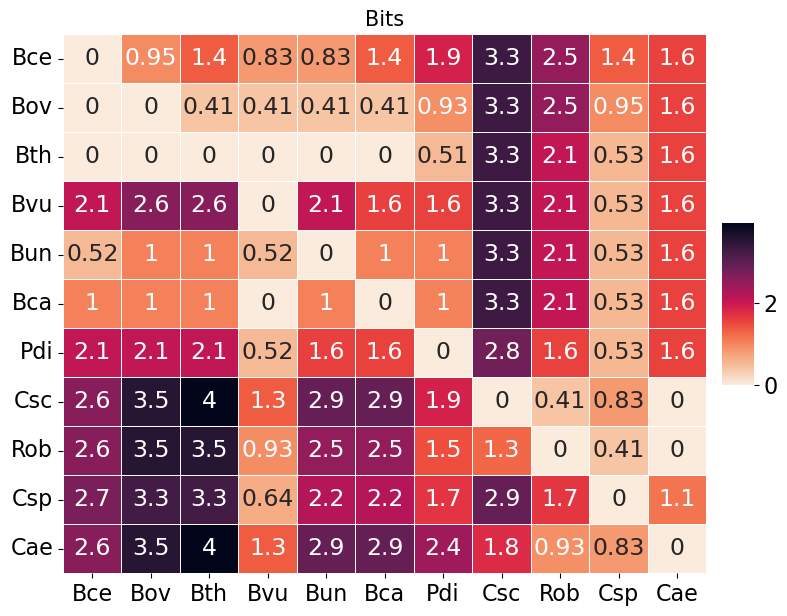

In [29]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_hf_carbo = exp_mcnulty.loc[1:81,['EC','Carbohydrate_metabolism']].dropna()
ecs_int_hf_carbo.drop(columns=['Carbohydrate_metabolism'], inplace=True)
ecs_int_hf_carbo = ecs_int_hf_carbo['EC'].str.split('; ', expand=True)
ecs_int_hf_carbo.reset_index(inplace=True)
ecs_int_hf_carbo = ecs_int_hf_carbo.melt(id_vars='Index', value_name='EC')
ecs_int_hf_carbo = ecs_int_hf_carbo.dropna()
ecs_int_hf_carbo = ecs_int_hf_carbo['EC'].values
print(ecs_int_hf_carbo.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_hf_carbo)]

metaddinfo_ECs_int_hf_carbo = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_hf_carbo = metaddinfo_ECs_int_hf_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_hf_carbo.to_csv('metabolic-metrics/metaddinfo_ECs_int_hf_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_hf_carbo_pretty = metaddinfo_ECs_int_hf_carbo.copy()
metaddinfo_ECs_int_hf_carbo_pretty.columns = metaddinfo_ECs_int_hf_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_hf_carbo_pretty.index = metaddinfo_ECs_int_hf_carbo_pretty.index.map(pretty_names_dir)
metaddinfo_ECs_int_hf_carbo_pretty = metaddinfo_ECs_int_hf_carbo_pretty.loc[order_hm, order_hm]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(metaddinfo_ECs_int_hf_carbo_pretty, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_hf_carbo.svg', bbox_inches='tight')
plt.show()

(19,)


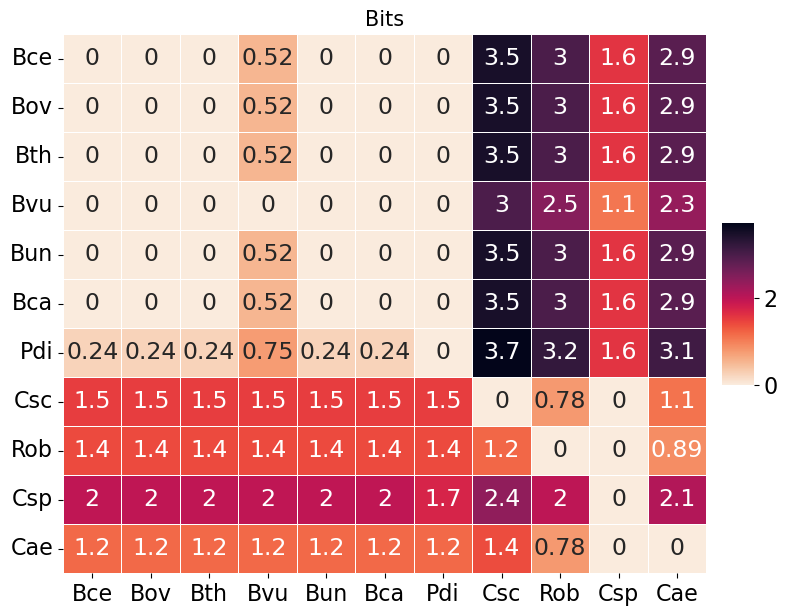

In [30]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_hf_amino = exp_mcnulty.loc[1:81,['EC','Aminocid_metabolism']].dropna()
ecs_int_hf_amino.drop(columns=['Aminocid_metabolism'], inplace=True)
ecs_int_hf_amino = ecs_int_hf_amino['EC'].str.split('; ', expand=True)
ecs_int_hf_amino.reset_index(inplace=True)
ecs_int_hf_amino = ecs_int_hf_amino.melt(id_vars='Index', value_name='EC')
ecs_int_hf_amino = ecs_int_hf_amino.dropna()
ecs_int_hf_amino = ecs_int_hf_amino['EC'].values
print(ecs_int_hf_amino.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_hf_amino)]

metaddinfo_ECs_int_hf_amino = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_hf_amino = metaddinfo_ECs_int_hf_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_hf_amino.to_csv('metabolic-metrics/metaddinfo_ECs_int_hf_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_hf_amino_pretty = metaddinfo_ECs_int_hf_amino.copy()
metaddinfo_ECs_int_hf_amino_pretty.columns = metaddinfo_ECs_int_hf_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_hf_amino_pretty.index = metaddinfo_ECs_int_hf_amino_pretty.index.map(pretty_names_dir)
metaddinfo_ECs_int_hf_amino_pretty = metaddinfo_ECs_int_hf_amino_pretty.loc[order_hm, order_hm]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(metaddinfo_ECs_int_hf_amino_pretty, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_hf_amino.svg', bbox_inches='tight')
plt.show()

(28,)


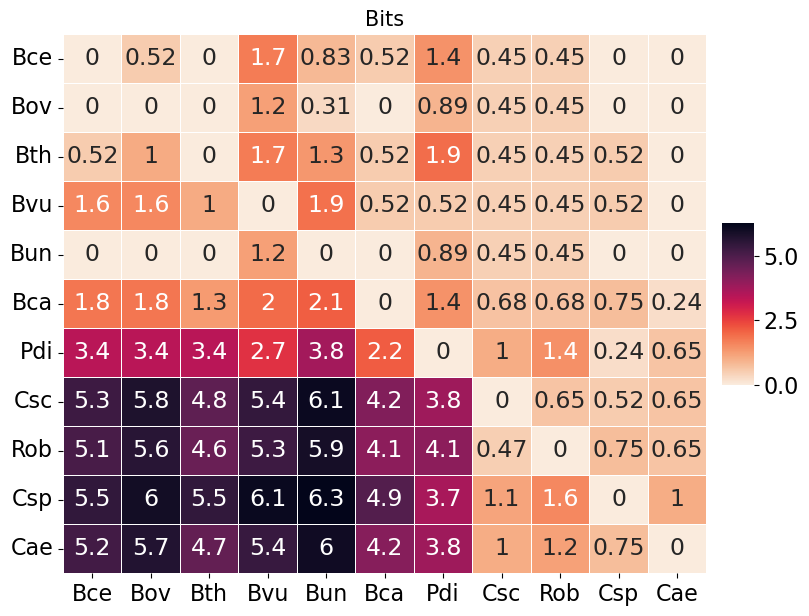

In [31]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_lf_carbo = exp_mcnulty.loc[82:158,['EC','Carbohydrate_metabolism']].dropna()
ecs_int_lf_carbo.drop(columns=['Carbohydrate_metabolism'], inplace=True)
ecs_int_lf_carbo = ecs_int_lf_carbo['EC'].str.split('; ', expand=True)
ecs_int_lf_carbo.reset_index(inplace=True)
ecs_int_lf_carbo = ecs_int_lf_carbo.melt(id_vars='Index', value_name='EC')
ecs_int_lf_carbo = ecs_int_lf_carbo.dropna()
ecs_int_lf_carbo = ecs_int_lf_carbo['EC'].values
print(ecs_int_lf_carbo.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_lf_carbo)]

metaddinfo_ECs_int_lf_carbo = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_lf_carbo = metaddinfo_ECs_int_lf_carbo.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_lf_carbo.to_csv('metabolic-metrics/metaddinfo_ECs_int_lf_carbo.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_lf_carbo_pretty = metaddinfo_ECs_int_lf_carbo.copy()
metaddinfo_ECs_int_lf_carbo_pretty.columns = metaddinfo_ECs_int_lf_carbo_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_lf_carbo_pretty.index = metaddinfo_ECs_int_lf_carbo_pretty.index.map(pretty_names_dir)
metaddinfo_ECs_int_lf_carbo_pretty = metaddinfo_ECs_int_lf_carbo_pretty.loc[order_hm, order_hm]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(metaddinfo_ECs_int_lf_carbo_pretty, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_lf_carbo.svg', bbox_inches='tight')
plt.show()

(25,)


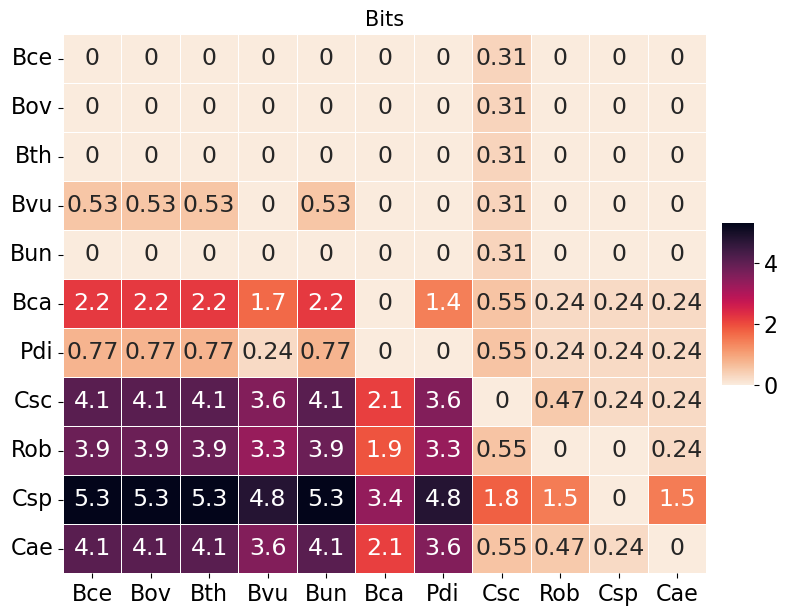

In [32]:
exp_mcnulty = pd.read_excel('expression_mcnulty.xlsx', index_col=0)
ecs_int_df_amino = exp_mcnulty.loc[82:158,['EC','Aminocid_metabolism']].dropna()
ecs_int_df_amino.drop(columns=['Aminocid_metabolism'], inplace=True)
ecs_int_df_amino = ecs_int_df_amino['EC'].str.split('; ', expand=True)
ecs_int_df_amino.reset_index(inplace=True)
ecs_int_df_amino = ecs_int_df_amino.melt(id_vars='Index', value_name='EC')
ecs_int_df_amino = ecs_int_df_amino.dropna()
ecs_int_df_amino = ecs_int_df_amino['EC'].values
print(ecs_int_df_amino.shape)
ECs_int_lf = ECs[ECs.index.isin(ecs_int_df_amino)]

metaddinfo_ECs_int_lf_amino = get_added_information(ECs_int_lf)
metaddinfo_ECs_int_lf_amino = metaddinfo_ECs_int_lf_amino.sort_index(axis=0).sort_index(axis=1)
metaddinfo_ECs_int_lf_amino.to_csv('metabolic-metrics/metaddinfo_ECs_int_lf_amino.tsv', sep='\t', index=True, header=True)
metaddinfo_ECs_int_lf_amino_pretty = metaddinfo_ECs_int_lf_amino.copy()
metaddinfo_ECs_int_lf_amino_pretty.columns = metaddinfo_ECs_int_lf_amino_pretty.columns.map(pretty_names_dir)
metaddinfo_ECs_int_lf_amino_pretty.index = metaddinfo_ECs_int_lf_amino_pretty.index.map(pretty_names_dir)
metaddinfo_ECs_int_lf_amino_pretty = metaddinfo_ECs_int_lf_amino_pretty.loc[order_hm, order_hm]
plt.figure(figsize=(10, 7))
ax = sns.heatmap(metaddinfo_ECs_int_lf_amino_pretty, 
    cmap=cmap, 
    annot=True, 
    annot_kws={'size': 17},
    linewidths=0.5,
    cbar_kws={'shrink': 0.3, 'aspect': 5, 'orientation':'vertical', 'pad': 0.02},
    xticklabels=True,
    )
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.title('Bits', fontsize=15)
plt.savefig('metabolic-metrics/metaddinfo_ECs_int_lf_amino.svg', bbox_inches='tight')
plt.show()